# Aufgabe-D-Schilder

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## VM zum Trainieren großer Modelle

- Nutzung des Clusters der DHBW
    - VPN-Endpunkt: drogon.dhbw-mannheim.de
    - Anmeldeseite Cluster: https://cloud.4c.dhbw-mannheim.de/
1. Ping external IP (Floating IP)
    1. Not working? --> New Floating IP
    2. Working --> ssh ubuntu@141.72.191.72 -i privatekey.txt

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/D_schilder herunter
    * Die Daten sind geschützt. 
    * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen ml_2021 anmelden. 
    



## Readme der Daten

This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming  
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the track number. All images of one class 
with identical track numbers originate from one single physical traffic sign.
The second part, YYYYY, is a running number within the track. The temporal order
of the images is preserved.


**********************************************
Annotation format
**********************************************

The annotations are stored in CSV format (field separator
is ";" (semicolon) ). The annotations contain meta information 
about the image and the class id.


In detail, the annotations provide the following fields:

Filename        - Image file the following information applies to
Width, Height   - Dimensions of the image
Roi.x1,Roi.y1,
Roi.x2,Roi.y2   - Location of the sign within the image
		  (Images contain a border around the actual sign
                  of 10 percent of the sign size, at least 5 pixel)
ClassId         - The class of the traffic sign


## Aufgabe

* die Daten 
    * enthalten mehr als 50000 Bilder von Verkehrsschilder auf deutschen Straßen
    * pro Klasse der Daten gibt es ein Verzeichnis
    * in jeder Klasse gibt eine CSV-Datei mit Annotationen der Bilder
        * Die Namen lauten GT-<ClassID>.csv
* die Bilder 
    * enthalten genau ein Verkehrszeichen, mit ca. 10% Rand um das Verkehrszeichen
    * sind im PPM Format gespeichert
    * die Größen der Bilder variieren von 15x15 Pixel bis zu 250x250 Pixel
        * die Bilder müssen aber nicht quadratisch sein
    * In den Annotationen ist auch die Bounding Box hinterlegt
* die Annotations-Datei hat den folgenden Werte
    * Dateiname, Width, Height, BB.x1, BB.y1, BB.x2, BB.y2, ClassId
        * BB steht für BoundingBox

Erstellen Sie ein tiefes neuronales Netz, dass Schilder in Bildern erkennt und die Position des erkannten Schilds als Bounding Box ausgibt! Die Lösung soll auch mehrere Schilder in einem Bild erkennen können! 


# Lokalisieren von Verkehrsschildern

Für das Lokalisieren von Objekten in Bildern werden überlicherweise Region Based Convolutional Neural Networks (R-CNNs) verwendendet. Diese Methode wurde mit der Zeit verbessert:
* November 2013: R-CNN
* April 2015: Fast R-CNN
* Juni 2015: Faster R-CNN
* März 2017: Mask R-CNN
* Juni 2019: Mesh R-CNN

Diese und weitere Ansätze und Algorithmen werden in verschiedenen Frameworks benutzt. Eines davon ist YOLO, welches später benutzt wird.

Im Folgenden wird mithilfe von Bounding Box Regression ein Maschine Learning Modell entwickelt, welches die Position in Form von Bounding Boxes von Verkehrsschildern erkennt.

Beispiel Bounding Box:
    TODO

## Image Generator

Da die vorliegenden Trainingsbilder bereits auf die Verkehrsschilder zugeschnitten sind und lediglich 10% Rand um diese aufweisen, wurde sich dazu entschieden syntetische Trainingsdaten aus den vorhandenen Trainingsbildern und neuen Hintergrundbildern zu generieren. \
Dafür wurde eine die Funktion\
generate_raster_sign_image(
*    number_of_images,
*    number_of_signs,
*    path_to_bg_img_folder,
*    pre_path_sign,
*    sign_size,
*    raster_width,
*    raster_height,
*    sign_with_clahe,
*    verbose=False,
*    show_images=False)

erstellt. Diese verwendet die beiden neu programmierten Funktionen *_get_random_signs()* und *_get_bg_images()* um zufällige Verkehrsschilder rasterförmig zufällig verteilt auf Hintergrundbilder zu platzieren.

Beispielbilder generate_raster_sign_image:
    TODO

Neben den generierten Bildern werden auch die Boundings Boxes und Labels als Liste von Dictionarys zurückgegeben. Keys: Bounding Boxes als Tuple und Classifier als Value.

## Imports
Lokal entwickelte Skripte und Module

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from display_data import ImageDisplayer
from image_detection import predict_and_display_img
from evaluation import plot_confusion_matrix
import collage

Externe Bibliotheken

In [2]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage import exposure, transform
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import mimetypes
import pickle
import cv2
import os

## Training mit einem Verkehrszeichen pro Bild

### Vorverarbeitung

In [3]:
file = open(r"./data_preprocessed/data_1.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"./data_preprocessed/labels_1.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [4]:
input_shape = data[0].shape

In [5]:
targets = []
for k in labels:
    e = next(iter(k)) #first BB is the only one
    x1, y1, x2, y2 = e #extract coordinates
    h, w = input_shape[:2]
    x1 = x1/w #scale with image shape
    y1 = y1/h
    x2 = x2/w
    y2 = y2/h
    targets.append((x1, y1, x2, y2))
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

### Aufteilen der Daten zu Trainings, Validierungs und Testdaten

In [6]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

### Modell erstellen

In [7]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 96, 3)]       0         
                                                                 
 bl_2 (Conv2D)               (None, 64, 96, 16)        448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 32, 48, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 32, 48, 32)        4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 16, 24, 32)        0         
                                                                 
 bl_6 (Conv2D)               (None, 16, 24, 64)        18496     
                                                                 
 bl_7 (MaxPooling2D)         (None, 8, 12, 64)         0     

In [8]:
loss = tf.keras.losses.MAE

In [9]:
model.compile(loss=loss, optimizer='Adam')

### Trainig starten

In [10]:
epoch_num = 2

In [11]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=10,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

Epoch 1/2
750/750 [==============================] - 25s 32ms/step - loss: 0.0493 - val_loss: 0.0179
Epoch 2/2
750/750 [==============================] - 24s 32ms/step - loss: 0.0160 - val_loss: 0.0176


### Modell abspeichern

In [12]:
model.save(r"models/models_regr_1_1", save_format="h5")

### Visualieren des Trainings

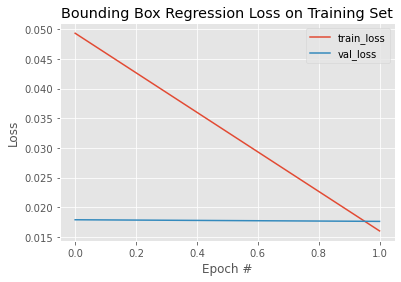

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Modell aus Datei laden

In [46]:
model = load_model(r"./models/models_regr_1")

### Anzeigen von Testbildern

In [15]:
for image, bounding in zip(testImages, testTargets):
    predict_and_display_img(model, image, bounding)

KeyboardInterrupt: 

## Training mit mehreren Verkehrsschilder

In [14]:
file = open(r"./data_preprocessed/data_3.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"./data_preprocessed/labels_3.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [15]:
targets = []
input_shape = data[0].shape
for k in labels:
    a = list(k.keys())
    a.sort(key=lambda x: (x[0], x[1])) ## wichtig! Erläuterung: nächste Zelle
    temp = [] #input vektor for model
    for e in a:
        x1, y1, x2, y2 = e #extract coordinates
        h, w = input_shape[:2]
        temp.append(x1/w) #scale with image shape
        temp.append(y1/h)
        temp.append(x2/w)
        temp.append(y2/h)
    targets.append(temp)
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

Es ist wichtig, dass das maschine learning modell zwischen den einzelnen verkehrsschildern unterscheiden kann. \
Dafür müssen die Bounding Boxen, bzw. die Koordinaten dieser, für den Eingabevektor immer eine spezielle Reihenfolge haben. \
Um dies zu erreichen wurde sich dazu entschieden, die Boxen nach ihrer X-Koordinaate der oberen linken Ecke zu sortieren. Bei gleichen Werten wird nach der Y-Koordiate entschieden.

Wird keine Sortierung vorgenommen, sieht das Ergebnis wie folgt aus: \
<img src="./images/3_signs_without_sort1.png">     <img src="./images/3_signs_without_sort2.png">\
Grün = Predicted Bounding Box, Rot = actual Bounding Box

In [16]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

### Modell erstellen

In [17]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(24, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Conv2D(48, 3, padding='same', activation='relu', name='bl_8')(base_layers)
base_layers = MaxPooling2D(name='bl_9')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_10')(base_layers)
base_layers = MaxPooling2D(name='bl_11')(base_layers)
base_layers = Conv2D(96, 3, padding='same', activation='relu', name='bl_12')(base_layers)
base_layers = MaxPooling2D(name='bl_13')(base_layers)
base_layers = Conv2D(128, 3, padding='same', activation='relu', name='bl_14')(base_layers)
base_layers = MaxPooling2D(name='bl_15')(base_layers)
base_layers = Flatten(name='bl_18')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(96, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(64, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(48, activation='relu', name='bb_4')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_5')(locator_branch)
locator_branch = Dense(16, activation='relu', name='bb_6')(locator_branch)
locator_branch = Dense(12, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 192, 3)]     0         
                                                                 
 bl_2 (Conv2D)               (None, 128, 192, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 64, 96, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 64, 96, 24)        3480      
                                                                 
 bl_5 (MaxPooling2D)         (None, 32, 48, 24)        0         
                                                                 
 bl_6 (Conv2D)               (None, 32, 48, 32)        6944      
                                                                 
 bl_7 (MaxPooling2D)         (None, 16, 24, 32)        0   

In [18]:
loss = tf.keras.losses.MAE

In [19]:
model.compile(loss=loss, optimizer='Adam')

### Trainig starten

In [22]:
epoch_num = 15

In [9]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=10,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

2022-03-15 16:44:03.382789: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4423680000 exceeds 10% of free system memory.


Epoch 1/15
1500/1500 [==============================] - 180s 120ms/step - loss: 0.1718 - val_loss: 0.1257
Epoch 2/15
1500/1500 [==============================] - 198s 132ms/step - loss: 0.1160 - val_loss: 0.1115
Epoch 3/15
1500/1500 [==============================] - 202s 135ms/step - loss: 0.1020 - val_loss: 0.0918
Epoch 4/15
1500/1500 [==============================] - 203s 136ms/step - loss: 0.0855 - val_loss: 0.0833
Epoch 5/15
1500/1500 [==============================] - 185s 123ms/step - loss: 0.0812 - val_loss: 0.0815
Epoch 6/15
1500/1500 [==============================] - 187s 125ms/step - loss: 0.0790 - val_loss: 0.0807
Epoch 7/15
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0755 - val_loss: 0.0758
Epoch 8/15
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0709 - val_loss: 0.0637
Epoch 9/15
1500/1500 [==============================] - 196s 131ms/step - loss: 0.0562 - val_loss: 0.0538
Epoch 10/15
1500/1500 [=======================

### Modell abspeichern

In [11]:
model.save(r"./models/models_regr_3signs_1", save_format="h5")

### Visualieren des Trainings

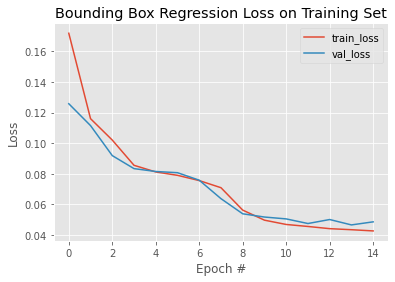

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.show()
plt.savefig('./images/training3_15_1.png')

### Modell aus Datei laden

In [20]:
model = load_model(r"./models/models_regr_3signs_1")

### Anzeigen von Testbildern

In [24]:
for image, bounding in zip(testImages, testTargets):
    predict_and_display_img(model, image, bounding)

KeyboardInterrupt: 

In [25]:
cv2.destroyAllWindows()

<img src="./images/3_signs_2.png">     <img src="./images/3_signs_3.png">

# Klassifizierung von Verkehrsschildern

## Dictionary für alle Klassen im Datensatz

Quelle für die meisten Bezeichnungen: https://www.adac.de/verkehr/recht/verkehrszeichen/

In [20]:
classes = { 0:'Geschwindigkeitsbegrenzung (20km/h)',
            1:'Geschwindigkeitsbegrenzung (30km/h)',      
            2:'Geschwindigkeitsbegrenzung (50km/h)',       
            3:'Geschwindigkeitsbegrenzung (60km/h)',      
            4:'Geschwindigkeitsbegrenzung (70km/h)',    
            5:'Geschwindigkeitsbegrenzung (80km/h)',      
            6:'Ende der Geschwindigkeitsbegrenzung (80km/h)',     
            7:'Geschwindigkeitsbegrenzung (100km/h)',    
            8:'Geschwindigkeitsbegrenzung (120km/h)',     
            9:'Überholverbot',   
           10:'Überholverbot >3.5t',     
           11:'Vorfahrt nächste Kreuzung',     
           12:'Vorfahrtsstraße',    
           13:'Vorfahrt gewähren',     
           14:'Stop',       
           15:'Verbot für Fahrzeuge aller Art',       
           16:'Verbot für Fahrzeuge >3.5t',       
           17:'Verbot der Einfahrt',       
           18:'Gefahrenstelle',     
           19:'Kurve (links)',      
           20:'Kurve (rechts)',   
           21:'Doppelkurve',      
           22:'Unebene Fahrbahn',     
           23:'Schleuder-/Rutschgefahr',       
           24:'Einseitig (rechts) verengte Fahrbahn',  
           25:'Arbeitsstelle',    
           26:'Lichtzeichenanlage', # zu deutsch: Ampel      
           27:'Fußgänger',     
           28:'Kinder',     
           29:'Radfahrer',       
           30:'Schnee-/Eisglätte',
           31:'Wildwechsel',      
           32:'Ende sämtlicher Geschw-begr./Überholverb.',      
           33:'Vorgeschriebene Fahrtrichtung rechts',     
           34:'Vorgeschriebene Fahrtrichtung links',       
           35:'Vorgeschriebene Fahrtrichtung gerade',      
           36:'Vorgeschriebene Fahrtrichtung gerade/rechts',      
           37:'Vorgeschriebene Fahrtrichtung gerade/links',      
           38:'Vorgeschriebene Vorbeifahrt rechts vorbei',     
           39:'Vorgeschriebene Vorbeifahrt links vorbei',      
           40:'Kreisverkehr',     
           41:'Ende Überholverbot',      
           42:'Ende Überholverbot >3.5t' 
          }

## Einlesen der Daten
Der Datensatz besteht aus 43 Ordnern, welche je eine Klasse abbilden.  
- Beispiel: In Ordner 0 liegen ausschließlich Bilder von Tempo 20 Schildern ab  

### Reader
Reader() stellt eine selbst entwickelte Klasse dar. <a href="./src/reader.py">Sie ist hier zu finden</a>.<br>
Diese iteriert durch alle Ordner und liest die Annotation-Files ein. Diese Informationen werden in einem pandas DataFrame gespeichert.  

In [21]:
reader = Reader()
df = reader.read_data_to_df(folders=43, pre_path=r"./data/")
df

,Filename,Folder,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,./data/0/,29,30,5,6,24,25,0
1,00000_00001.ppm,./data/0/,30,30,5,5,25,25,0
2,00000_00002.ppm,./data/0/,30,30,5,5,25,25,0
3,00000_00003.ppm,./data/0/,31,31,5,5,26,26,0
4,00000_00004.ppm,./data/0/,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...,...
39204,00007_00025.ppm,./data/42/,52,56,5,6,47,51,42
39205,00007_00026.ppm,./data/42/,56,58,5,5,51,53,42
39206,00007_00027.ppm,./data/42/,58,62,5,6,53,57,42
39207,00007_00028.ppm,./data/42/,63,69,5,7,58,63,42


### Beschreibung der Daten
Der Datensatz besteht aus 39209 Einträgen, welcher sich in 43 Klassen unterteilt.  
Jeder Eintrag stellt ein Bild dar, welches eine gewissen Breite und Höhe besitzt. **Die Bilder besitzen also nicht die gleiche Größe.**  
Zudem ist die "Bounding Box" durch die 4 Spalten beginnend mit Roi abgebildet. (X1, Y1) spannt mit (X2, Y2) ein Rechteck auf, in welchem sich das Verkehrszeichen befinden soll.

Zusätzlich wird der Pfad zu der einzelnen Bilder gespeichert. Der Grund hierfür ist die Nicht-Eindeutigkeit der Dateinamen über den eigenen Ordner hinaus.  
Dies geht auch aus dem Readme der Daten hervor (ein Dateiname besteht aus Track und Tracknummer).  

In [22]:
lookup_filename = "00000_00000.ppm"
print("Vorkommnisse von " + lookup_filename + ":")
print(len(df.index[df["Filename"] == lookup_filename]))

print()

lookup_folder_with_filename = r"./data/0/00000_00000.ppm"
print("Vorkommnisse von " + lookup_folder_with_filename + ":")
print(len(df.index[df["Folder"] + df["Filename"] == lookup_folder_with_filename]))

Vorkommnisse von 00000_00000.ppm:
43

Vorkommnisse von ./data/0/00000_00000.ppm:
1


In [23]:
#ImageDisplayer(df, 100, 105)

## Plots zur Veranschaulichung des Datensatzes
### Ausgewogenheit

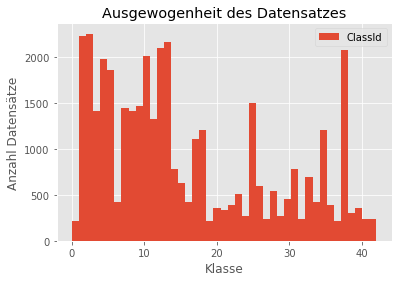

In [24]:
df.plot(y="ClassId", kind="hist", bins=len(set(df["ClassId"])))
plt.title("Ausgewogenheit des Datensatzes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

Der Datensatz ist sehr **unausgewogen**. Einige Klassen verfügen über sehr viele Datensätze, während andere nur sehr wenige besitzen.
Das neuronale Netz könnte zu sehr auf einige Klassen trainiert werden, daher sollte eine Angleichung der Menge der Datensätze pro Klasse stattfinden.  
Am Beispiel der Klassen 0 und 1:

In [25]:
print("Anzahl Datensätze 20er Schild:", len(df[df["ClassId"] == 0]))
print("Anzahl Datensätze 30er Schild:", len(df[df["ClassId"] == 1]))
print("Faktor:", round(len(df[df["ClassId"] == 1])/len(df[df["ClassId"] == 0]), 2))

Anzahl Datensätze 20er Schild: 210
Anzahl Datensätze 30er Schild: 2220
Faktor: 10.57


### Bildbreite und Höhe

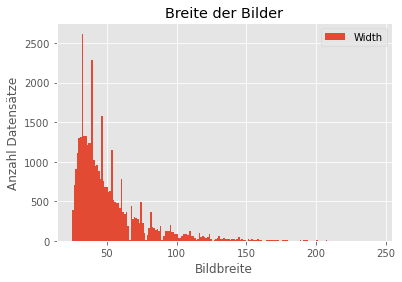

In [26]:
df.plot(y="Width", kind="hist", bins=len(set(df["Width"])))
plt.title("Breite der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildbreite")
plt.show()

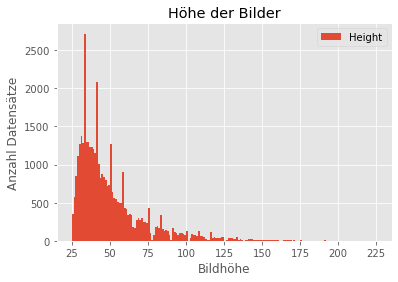

In [27]:
df.plot(y="Height", kind="hist", bins=len(set(df["Height"])))
plt.title("Höhe der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildhöhe")
plt.show()

Die Bilder verfügen über unterschiedliche Höhen und Breiten. Der Großteil der Bilder ist bis zu 50 Pixeln breit und bis zu ca. 60 Pixeln hoch.  
Auffällig sind einige "Spikes" in den Grafiken, was bedeutet, dass viele Bilder die gewisse Breite oder Höhe besitzen.  

### Bildfläche

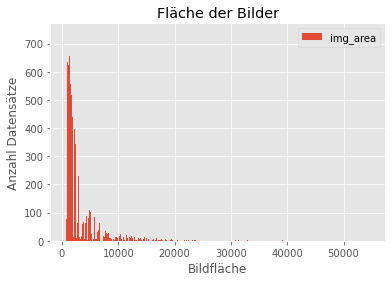

In [28]:
df["img_area"] = df["Width"]*df["Height"]
df.plot(y="img_area", kind="hist", bins=len(set(df["img_area"])))
plt.title("Fläche der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildfläche")
plt.show()

Folgend aus den Höhen und Breiten sind die Bildflächen verschieden.  
Auch hier befinden sich die meisten Einträge im unteren Spektrum der x-Achse.

### Bounding-Box Länge, Höhe und Fläche

In [29]:
df["x_box_len"] = df["Roi.X2"] - df["Roi.X1"]
df["y_box_len"] = df["Roi.Y2"] - df["Roi.Y1"]
df["box_area"] = df["x_box_len"]*df["y_box_len"]

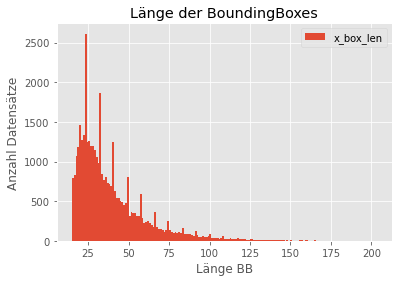

In [30]:
df.plot(y="x_box_len", kind="hist", bins=len(set(df["x_box_len"])))
plt.title("Länge der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Länge BB")
plt.show()

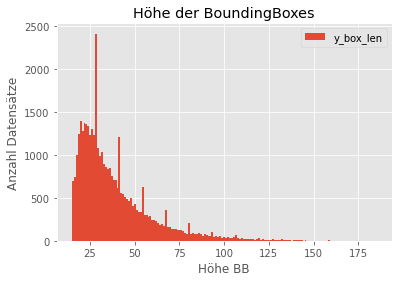

In [31]:
df.plot(y="y_box_len", kind="hist", bins=len(set(df["y_box_len"])))
plt.title("Höhe der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Höhe BB")
plt.show()

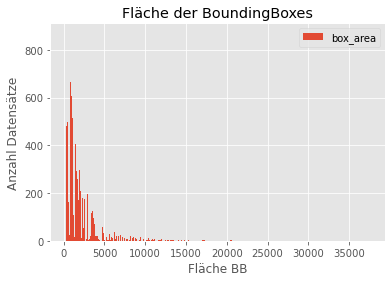

In [32]:
df.plot(y="box_area", kind="hist", bins=len(set(df["box_area"])))
plt.title("Fläche der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Fläche BB")
plt.show()

Die Bounding-Boxes verhalten sich wie die Bilder selbst. Auch hier sind einige "Spikes" bei der Höhe und Breite zu erkennen.  
Die meisten Bounding-Boxes sind bis zu ca. 40 Pixel hoch und breit.  
Dies kann für die spätere Transformation der Größe genutzt werden, da die zugeschnitten Bilder später alle die gleiche Maß besitzen müssen.

## Bildklassifizierung
### Vorbereitung

#### Darstellung und Überblick
Um ein Gefühl für die Daten zu bekommen, wird eine Collage erstellt, die jedes 500. Bild darstellt.

In [33]:
collage.create_collage(r"./images/collage_cropped_images.png", df)

Darstellungen ohne weitere Nachbearbeitung (nur Zuschnitt auf Bounding Box):

<img src="./images/collage_cropped_images.png">

Es ist auffällig, dass die Qualität der Bilder stark unterschiedlich ist:
- Einige Bilder sind extrem dunkel und besitzen einen geringen Kontrast. 
- Durch das Skalieren der Bilder unterscheidet sich die Auflösung stark.

Teilweise sind Schilder selbst für ein menschliches Auge nicht eindeutig identifizierbar.  
**************
Es sind folgende Gemeinsamkeiten festzustellen:
- Der Bildwinkel ist immer gleich
- Die Schilder sind vollständig abgebildet und besitzen keine "Störungen" (Überdeckungen, Verunreinigungen, ...)

Dies lässt die Frage offen, ob ein späteres Modell Bilder aus dem "echten" Leben erkennen kann.

Im Zuge der Recherche für die Datenvorbereitung fiel ein <a href="https://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7">Paper</a> auf, welches ein Verfahren namens "CLAHE" nutzte um einen größeren Kontrast herzustellen.<br>
Beim späteren Trainieren neuronaler Netze kann betrachtet werden, ob dies einen signifikanten Unterschied bei der Leistung des Modells mit sich bringt.

Um die Auswirkungen des Verfahrens zu testen, wird eine Collage der angepassten Bilder erstellt. 

In [34]:
collage.create_preprocessed_collage(r"./images/collage_preprocessed_images.png", df)

Bilder mit Nachbearbeitung (höherer Kontrast):

<img src="./images/collage_preprocessed_images.png">

### Daten einlesen
Um das neuronale Netz trainieren zu können, werden die Eingabedaten und Labels benötigt.  
Auf Grund der vorherigen Schritte ist es möglich, über das erstellte DataFrame zu iterieren und jedes einzelne Bild auszulesen und zu bearbeiten. Im Anschluss daran wird es einer List hinzugefügt, was am Ende des Prozesses alle Bilder beinhaltet.   
Das **data**-Array beinhaltet alle Bilddaten
Das **labels**-Array beinhaltet die Klassenzugehörigkeiten 

#### read_preprocess_img
Die Bilder werden mit OpenCV eingelesen und auf die Maße der Bounding Box zugeschnitten. Im Anschluss folgt eine Anpassung der Bildgröße, damit alle Images eine einheitliche Größe besitzen.   
Als nächster Schritt folgt eine Histogramm-Equalization. Dies hat als Ziel, das Histogramm der Bilder jeweils so anzupassen, dass alle Grauwerte möglichst gleichverteilt sind. Bei der Histogramm Equalization berechnen sich die Grauwerte der Pixel wie folgt: 

$y=f(p)= \frac{L-1}{N}\int_{-\infty}^{p} h_{i}(p) \,dp$

Mit: x - alter Grauwert; N - Anzahl Pixel; L - Anzahl möglicher Grauwerte

In unserem Fall stützen wir uns auf die von skimage implementierte Funktion ```equalize_adapthist```, was ein Problem der einfachen Histogramm Equalization löst, bei welchem Informationsverlust in den Bildern auftritt. Es nutzt die Contrast Limited Adaptive Histogram Equalization (CLAHE). Eine Visualisierung der normalisierten Bilder kann in der weiter oben dargestellten Collage betrachtet werden.


Im Anschluss werden die Arrays in numpy-Arrays umgewandelt.

#### Einlesen vorbereiteter Daten
Um die vorbereiteten Daten systemübergreifend zur Verfügung stellen zu können, wurden die vorbereiteten Trainings und Testdaten in pkl-Dateien gespeichert. Diese stehen auch im kaggle-Datensatz zur Verfügung (siehe <a href=https://www.kaggle.com/nickkr/sign-detection>Kaggle-Datensatz: data_preprocessed</a>). Um nicht unnötig erneut einige Vorbereitungsschritte durchzuführen, wurde die Variable NO_PREPARED_DATA eingeführt. Diese ist im Laufe des Notebooks noch an einigen Stellen in der Datenvorbereitung zu finden.

In [35]:
NO_PREPARED_DATA = True

pickle_folder = f"./data_preprocessed"

try:
    with open(os.path.join(pickle_folder, 'X_train.pkl'), 'rb') as f:
        X_train = pickle.load(f)

    with open(os.path.join(pickle_folder, 'y_train.pkl'), 'rb') as f:
        y_train = pickle.load(f)

    with open(os.path.join(pickle_folder, 'X_val.pkl'), 'rb') as f:
        X_test = pickle.load(f)

    with open(os.path.join(pickle_folder, 'y_val.pkl'), 'rb') as f:
        y_test = pickle.load(f)
    NO_PREPARED_DATA = False
except:
    print("No already preprocessed data")
print(NO_PREPARED_DATA)

False


In [37]:
data = []
labels = []

for index, row in df.iterrows(): 
    if index>0 and index%5000 == 0:
        print("Iterated through", index, "images")
    elif index+1 == len(df):
        print("Iterated through all images")

    x = row["Roi.X1"]
    y = row["Roi.Y1"]
    h = row["Roi.Y2"]-row["Roi.Y1"]
    w = row["Roi.X2"]-row["Roi.X1"]

    data.append(Reader.read_preprocess_img(Reader, row["Folder"]+row["Filename"], (32,32), x, y, h, w))
    labels.append(int(row["ClassId"]))

data = np.array(data)
labels = np.array(labels)

Iterated through 5000 images
Iterated through 10000 images
Iterated through 15000 images
Iterated through 20000 images
Iterated through 25000 images
Iterated through 30000 images
Iterated through 35000 images
Iterated through all images


### Daten-Augmentierung
Bei der Augmentierung sollen die Daten transformiert werden.  
Dabei werden die herausgestellten Herausforderungen und Probleme des Datensatzes in Angriff genommen. Identifizierte Probleme:
1. Unausgewogenheit des Datensatzes
2. Immer gleiche Blickwinkel und keine "Störungen" (nichts verdeckt...)

Für Punkt eins ist eine Lösung, mehr Bilder aus dem Datensatz zu generieren und dabei die Klassen gleich zu verteilen.  
Da die Augmentierung viel Zeit in Anspruch nimmt, wird sie nicht ausgeführt, wenn die vorbereiteten Daten bereits aus zuvor erstellten pkl-Dateien gewonnen werden konnten.

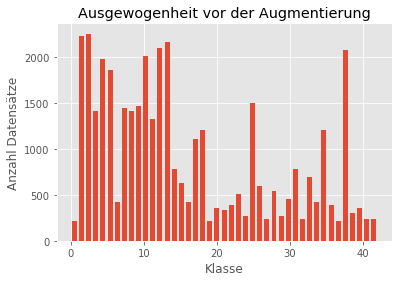

In [38]:
plt.hist(labels, bins=len(set(labels)), rwidth=0.7)
plt.title("Ausgewogenheit vor der Augmentierung")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

Die Daten werden mit Hilfe des ```ImageDataGenerator``` (siehe <a href=https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used-in-the-notebooks_1>Dokumentation</a>) augmentiert. Dieser ermöglicht es, neue Bilder aus den bestehenden zu erzeugen. Dabei können mehrere Parameter gesetzt werden.  
Auf horizontale und vertikale Spiegelungen wird verzichtet, da die Schilder in echt auch nicht "auf dem Kopf" stehen.

In [39]:
if NO_PREPARED_DATA:
    datagen = ImageDataGenerator(
        zca_whitening=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,
        channel_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
    )
    datagen.fit(data)

Es folgt die Augmentierung der Daten.  
Im Prozess wird eine Anzahl an Bildern (6000) festgelegt und für jede Klasse diese Anzahl an Bildern produziert. Nachdem die Bilder für alle Klassen erzeugt wurden, sollte der Datensatz also $ 43*6000=258000 $ Bilder beinhalten.

In [40]:
if NO_PREPARED_DATA:
    images_per_class = 6000
    data_aug = np.empty((0, 32, 32, 3))
    labels_aug = np.empty(0, dtype='int32')

    for i in tqdm(range(len(set(labels)))):
        # Get images and labels for each class
        index = [labels==i]
        i_data = data[tuple(index)]
        i_labels = labels[tuple(index)]

        i_data_aug = np.copy(i_data)
        i_labels_aug = np.copy(i_labels)

        # append augmented data to existing class-data
        for X, y in datagen.flow(i_data, i_labels, batch_size=len(i_labels), seed=3*i+52):
            i_data_aug = np.append(i_data_aug, X, axis=0)
            i_labels_aug = np.append(i_labels_aug, y, axis=0)

            if len(i_labels_aug) >= images_per_class:
                break

        # append data to result arrays
        # limit to appending images to maximum images (take rows up to rownumber specified)
        data_aug = np.append(data_aug, i_data_aug[:images_per_class], axis=0)
        labels_aug = np.append(labels_aug, i_labels_aug[:images_per_class], axis=0)


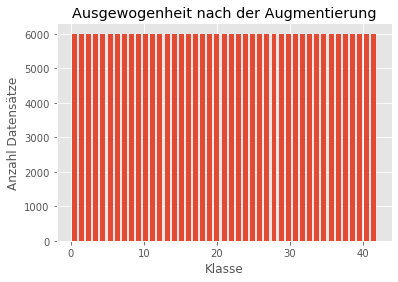

In [41]:
if NO_PREPARED_DATA:
    plt.hist(labels_aug, bins=len(set(labels_aug)), rwidth=0.7)
else:
    #reverse to_categorical and append test to train data (to get full dataset)
    con_labels = np.argmax(np.append(y_train, y_test, axis=0), axis=1) 
    plt.hist(con_labels, bins=len(set(con_labels)), rwidth=0.7)
plt.title("Ausgewogenheit nach der Augmentierung")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

In [42]:
if NO_PREPARED_DATA:
    print("Pre-defined data shape:",data.shape)
    print("Data shape after augmentation:",data_aug.shape)
    print("--> Anzahl Datensätze:", len(data_aug))
else:
    print("Pre-defined data shape:",data.shape)
    print("Train-data shape after augmentation:",X_train.shape)
    print("--> Anzahl Datensätze:", len(np.append(y_train, y_test, axis=0)))

Pre-defined data shape: (39209, 32, 32, 3)
Train-data shape after augmentation: (193500, 32, 32, 3)
--> Anzahl Datensätze: 258000


Nach der Augmentierung und Anpassung ist festzustellen, dass ein ausgeglichener Datensatz entstanden ist.  
Die Shape der Bilder hat sich nicht geändert, ausschließlich die Anzahl ist gestiegen.

### Darstellung des vorverarbeiteten Datensatzes

In [41]:
line = []
columns = []
for index in range(0,90):
    image = X_train[index]*255
    line.append(image)
    if len(line) == 13:
        columns.append(np.hstack(line))
        line = []
collage = np.vstack(columns)
collage = cv2.convertScaleAbs(collage, alpha=255.0)
cv2.imwrite(r"./images/collage_augmented_images.png", collage)

True

Im Foldenden sind die vollständig vorverarbeiteten Verkehrsschilder zu erkennen. Durch die Augmentierung sind viele Schilder nicht durch den Menschen erkennbar, allerdings hilft es in unserem Fall, das Overfitting-Problem einzuschränken.   
Die vorher immer gleichen Bilder sind nun sehr unterschiedlich und undeutlich dargestellt, wodurch das Modell nicht "auswendig lernen" kann. 
<img src="./images/collage_augmented_images.png">

### Aufteilung
Aufteilung in Trainings-/Test- und Validierungsdaten  

**Trainingsdaten**  
Dienen zum Training des neuronalen Netzes. Mit 75% des gesamten Datensatzes wird hier der Großteil der Daten genutzt.

**Validierungsdaten**  
Dienen zum Testen des neuronalen Netzes während des Trainings. Hierfür werden 12.5% der Daten vorgehalten.

**Testdaten**  
Dienen zur Evaluation des neuronalen Netzes nach dem Training. Validierungsadaten eignen sich hier nicht, da das neuronale Netz diese Daten bereits "gesehen" hat. Es dient als weitere Instanz, Über und Unteranpassung zu erkennen. Der Testdatensatz umfasst 12.5% des Datensatzes.

In [36]:
if NO_PREPARED_DATA:
    # train and test (0.75, 0.25)
    X_train, X_test, y_train, y_test = train_test_split(data_aug, labels_aug, test_size=0.25, random_state=1234)
    
    # save preprocessed data 
    with open('X_train.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    
    with open('y_train.pkl', 'wb') as f:
        pickle.dump(y_train, f)

    with open('X_val.pkl', 'wb') as f:
        pickle.dump(X_test, f)

    with open('y_val.pkl', 'wb') as f:
        pickle.dump(y_test, f)

# split test in val and test (0.5, 0.5 of test-data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1234)

In [37]:
if NO_PREPARED_DATA:
    # Scale to [0,1]
    X_train = X_train.astype("float32")/255.0
    X_test = X_test.astype("float32")/255.0
    X_val = X_val.astype("float32")/255.0

    # One-Hot Encoding (dont drop one column)
    print("y-shape before" + y_train.shape)
    y_train = to_categorical(y_train, 43)
    print("y-shape after" + y_train.shape)
    y_test = to_categorical(y_test, 43)
    y_val = to_categorical(y_val, 43)

### CNN / Klassifizierung
#### Auswahl des CNN mittels ```keras_tuner```

Der keras tuner hilft bei der Bestimmung der Hyperparameter. Dafür werden im Modell spezielle Parameter-Bereiche gesetzt, welche im Anschluss getestet werden.   
Als Resultat ergibt sich ein Modell, welches in Bezug auf die angegebenen Metriken am Besten performt hat.   
Das Ausprobieren dauert ohne GPU sehr lange, weshalb die unterhalb auffindbaren Code-Blöcke nicht nochmals ausgeführt werden sollen. Sie dienen als Grundlage für den Aufbau des finalen CNNs.

In [38]:
class TrafficSignNetworkTuner:
    @staticmethod
    def build_tuner(hp):
        width = 32
        height = 32
        depth = 3
        classes = 43
        model = Sequential()
        inputShape = (height, width, depth)
        
        for i in range(hp.Int('conv_blocks', 2, 5, default=3)):
            filters = hp.Int('filters_' + str(i), 8, 64, step=8)
            # CONV => RELU => BN => POOL
            model.add(Conv2D(filters, (5, 5), padding="same",
                input_shape=inputShape))
            model.add(Activation("relu"))
            model.add(BatchNormalization())
            
            pool_choice = hp.Choice('pooling_' + str(i), ['avg', 'max', ''])
            if pool_choice == 'max':
                model.add(MaxPooling2D(pool_size=(2, 2)))
            elif pool_choice == 'avg':
                model.add(AvgPool2D(pool_size=(2, 2)))
        
        for i in range(hp.Int('fully_connected', 1, 3, default=2)):
            # first set of FC => RELU layers
            hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
            model.add(Flatten())
            model.add(Dense(hp_units))
            model.add(Activation("relu"))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
                
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        chosen_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=chosen_loss,
                metrics=['accuracy'])
        
        # return the constructed network architecture
        return model

In [39]:
tuner = kt.Hyperband(
    TrafficSignNetworkTuner.build_tuner,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=1,
    seed=1234,
    project_name='kt_signdetection_network',
    overwrite=False
    )

INFO:tensorflow:Reloading Oracle from existing project .\kt_signdetection_network\oracle.json
INFO:tensorflow:Reloading Tuner from .\kt_signdetection_network\tuner0.json


In [40]:
RUN_TUNER = False
if RUN_TUNER:
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=30,
                 batch_size=128,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])
else:
    tuner.reload()

Resultate der Tuner-Suche:    
```
Trial 91 Complete [00h 02m 47s]
val_accuracy: 0.9670542478561401

Best val_accuracy So Far: 0.994217038154602
Total elapsed time: 00h 48m 44s
INFO:tensorflow:Oracle triggered exit
```

In [41]:
print(tuner.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0

In [42]:
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

{'conv_blocks': 3, 'filters_0': 32, 'pooling_0': 'max', 'filters_1': 32, 'pooling_1': '', 'filters_2': 40, 'pooling_2': 'avg', 'fully_connected': 2, 'units_0': 288, 'units_1': 64, 'learning_rate': 0.001, 'filters_3': 32, 'pooling_3': 'avg', 'filters_4': 56, 'pooling_4': '', 'units_2': 96, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '839e8d6be0425798d8d348420567f2d9'}


### Modelltraining
Mit Hilfe der bestimmten Hyperparameter wird das CNN aufgebaut. Um das Modelltraining zu beschleunigen, wurde es ausgelagert. Das Modelltraining ist in Notebook: <a href="Modelltraining Schilder Klassifizierung.ipynb">Modelltraining Schilder Klassifizierung.ipynb</a> zu finden.  
Das Modell wird hier schematisch dargestellt:   
<img src="./images/CNN_classification.png">

In [43]:
class TrafficSignNetwork:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        
        # first convolutional block
        model.add(Conv2D(32, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # second convolutional block
        model.add(Conv2D(32, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        
        # third convolutional block
        model.add(Conv2D(40, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(AvgPool2D(pool_size=(2, 2)))
        
        # first fully connected
        model.add(Flatten())
        model.add(Dense(288))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # second fully connected
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

Die Gewichte des bereits trainierten Modells werden eingeladen.

In [57]:
INIT_LR = 0.001

opt = Adam(learning_rate=INIT_LR)
model_classification = TrafficSignNetwork.build(width=32, height=32, depth=3, classes=43)
# Umsetzung der Empfehlung, die logit-Variante vorzuziehen
model_classification.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"])
model_classification.load_weights("./models/fin_model_15ep.h5")

## Evaluation

### Entwicklung der Ergebnisse
    
Im Laufe der Entwicklung dieses Projekts wurden mehrere Modelle trainiert. Diese sind hier nicht mehr dargestellt, daher werden folgend "lessons learned" bezüglich des Modelltrainings beschrieben.  

Anfangs wurde eine geringe Anzahl an convolutional-Blöcken (weniger als drei) und eine hohen Epochenanzahl verwendet. Dabei kam es nach ca 15-20 Epochen zu starkem Overfitting. Die Modell-Accuracy auf den Validierungsdaten lag im Bereich 80-95% und tiefer (Overfitting).  
Daher wurde ein keras_tuner Lauf durchgeführt, welcher verschiedene Modelle trainiert und miteinander vergleicht (Beschreibung siehe CNN/Klassifizierung). Beim Training des besten Modells stellte sich heraus, dass auch hier sehr schnell Overfitting stattfindet (nach 15-20 Epochen). Allerdings befindet sich die Accuracy auf den Validierungsdaten nun im Bereich >99%. Eine Evaluierung auf den Testdaten muss diese Zahl noch bestätigen.

In [58]:
model_classification.evaluate(X_test, y_test)

C:\Users\NickK\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1008/1008 [==============================] - 16s 15ms/step - loss: 0.0218 - accuracy: 0.9939


[0.02182062342762947, 0.9939224720001221]

Die Evaluation bestätigt das vorläufige Ergebnis und stellt mit 99.4% eine absolut zufriedenstellende Accuracy dar. In einer Reihe weiterer Darstellungen wird die Leistung des Modells weiter abgebildet.  
Um mit den Vorhersagen weiter arbeiten zu können, müssen diese auf Basis der Testdaten erst noch bestimmt werden.

In [59]:
preds = model_classification.predict(X_test)
preds = tf.argmax(preds, axis=1)

### Konfusionsmatrix
Mit Hilfe einer Konfusionsmatrix kann visuell die Leistung des Modells bestimmt werden. Hier wird sie auf die Vorhersage der Testdaten angewendet. Bei der Nutzung von 43 Klassen ist diese Darstellung schwierig, bzw. sind die einzelnen Zahlen sehr schlecht zu erkennen. Die Farben ergeben allerdings ein gutes Bild über die Verteilung.  

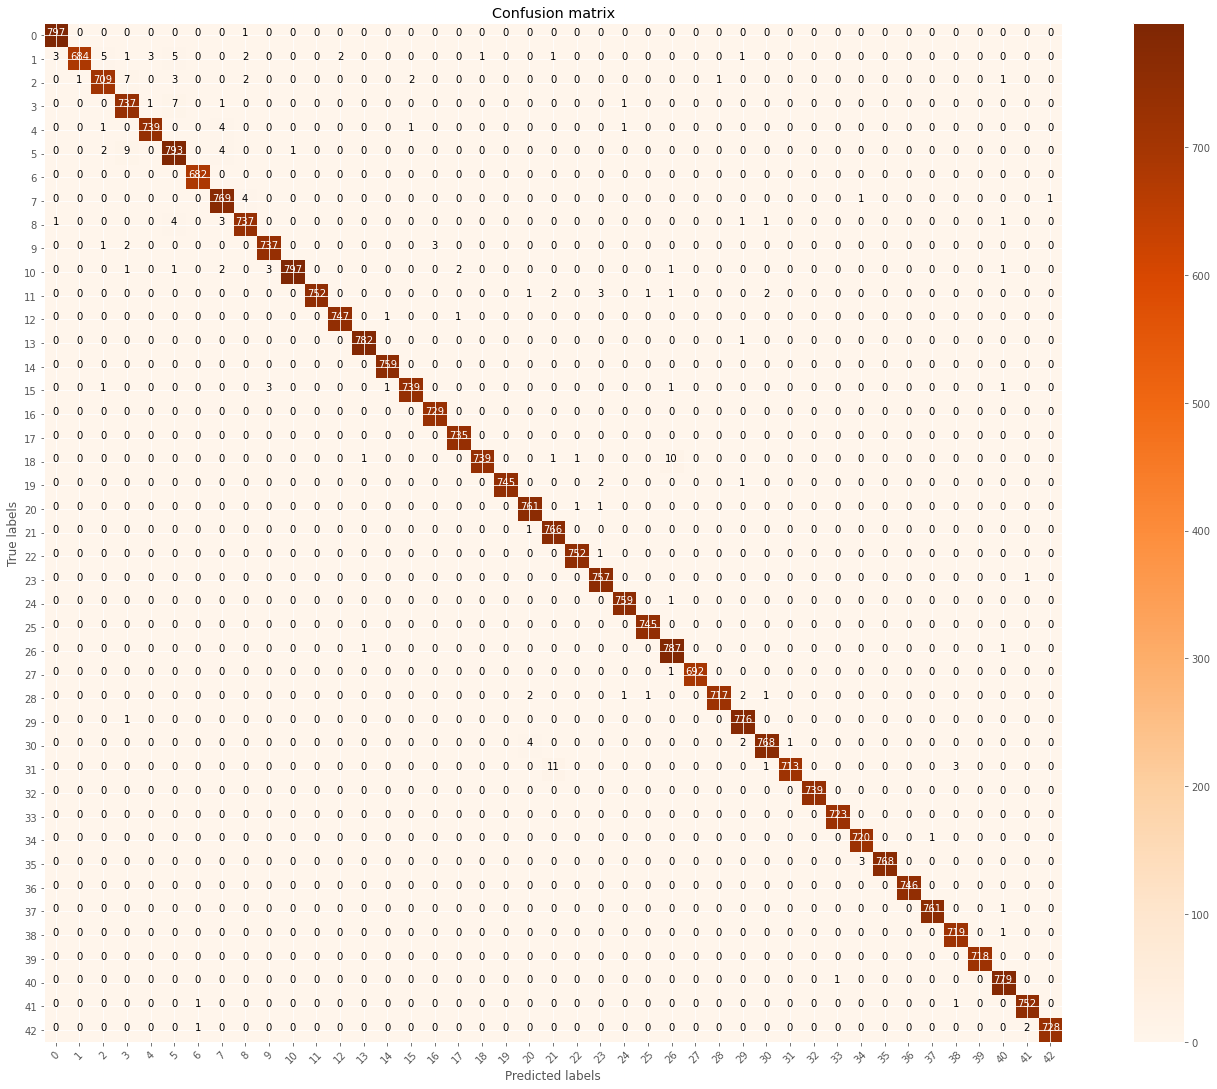

In [60]:
# Aufbau + Plot der Confusion Matrix
cm = confusion_matrix(tf.argmax(y_test, axis=1).numpy(), preds.numpy())  
plot_confusion_matrix(cm, tuple(classes))

Es ist deutlich erkennbar, dass die Diagonale (korrekte Klassifizierungen) farblich sehr deutlich markiert ist, während alle anderen Zellen (falsche Klassifizierungen) auf Basis ihrer Farbe im Bereich 0 liegen.
### Darstellung falscher Klassifizierungen

In [61]:
wrong_preds = preds.numpy() !=  tf.argmax(y_test, axis=1).numpy()
wrong_preds_index = np.where(wrong_preds == True)
print("Falsche Vorhersagen:", len(wrong_preds_index[0]), "von:", len(preds.numpy()))

Falsche Vorhersagen: 196 von: 32250


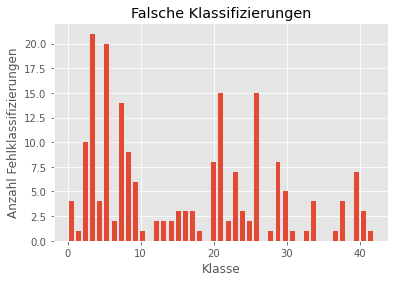

In [62]:
right_labels = tf.argmax(y_test, axis=1)
right_labels = np.array(right_labels)
right_labels = right_labels[wrong_preds_index]

wrong_predictions = np.array(preds)
wrong_predictions = wrong_predictions[wrong_preds_index]

wrong_predicted_images = X_test[wrong_preds_index]

# labels = range(0,43)
plt.hist(wrong_predictions, bins=43, rwidth=0.7)
plt.title("Falsche Klassifizierungen")
plt.ylabel("Anzahl Fehlklassifizierungen")
plt.xlabel("Klasse")
plt.show()

In [63]:
# die 5 am meisten fehlklassifizierten Klassen
list_wrong_preds = list(wrong_predictions)
most_wrongs = []
def most_common(lst):
    return max(set(lst), key=lst.count)

for i in range(0, 5):
    classid = most_common(list_wrong_preds)
    try:
        while True:
            list_wrong_preds.remove(classid)
    except ValueError:
        pass
    most_wrongs.append(classid)
most_wrongs

[3, 5, 21, 26, 7]

In [64]:
for element in most_wrongs:
    print(classes[element])

Geschwindigkeitsbegrenzung (60km/h)
Geschwindigkeitsbegrenzung (80km/h)
Doppelkurve
Lichtzeichenanlage
Geschwindigkeitsbegrenzung (100km/h)


# Verbindung der Objekterkennung und Klassifizierung
## Anwendung der Modelle auf Bilder aus dem Straßenverkehr
In einem letzten Schritt soll die Zusammenarbeit zwischen Objekterkennung und Klassifizierung getestet werden. Dafür haben wir einen Datensatz benutzt, welcher 900 reale Bilder aus dem Straßenverkehr verwendet. Dieser wurde von den Erstellern des Datensatzes gelabelt (Bounding Box und Klasse).  
Die Datenstruktur stimmt mit der aus dem Trainingsdatensatz überein, sprich es sind 43 Klassen vorhanden, die Klassenbezeichnungen stimmen mit dem Trainingsdatensatz überein.  

In [65]:
reader = Reader()
df_test = reader.read_test_data_to_df(pre_path="./test_data/")
df_test

,Filename,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39
...,...,...,...,...,...,...
1208,00896.ppm,808,412,846,450,15
1209,00897.ppm,804,526,828,550,42
1210,00898.ppm,323,504,355,536,4
1211,00898.ppm,817,510,849,542,4


Die Anzahl der Zeilen lässt darauf schließen, dass die Test-Bilder über mehrere Klassen verfügen können. In den Zeilen 1-3 des DataFrame ist dies auch zu erkennen.
## Ablauf
Zuerst sollen Bounding Boxes durch das Objekterkennungsmodell bestimmt werden. Im Abschluss übergibt dieser Arbeitschritt die Bilder und Bounding Boxes an die Schilderklassifizierung weiter. Die Accuracy der Vorhersagen kann mit denen verglichen werden, die das Modell anhand der "originalen" Bounding Boxes erreicht. So ist die Leistung der gesamten Kette messbar.

In [70]:
test_data_with_cut_bb = []
test_labels = []
test_data_full_img=[]
folder = r"./test_data/"
for index, row in df_test.iterrows(): 
    if index>0 and index%250 == 0:
        print("Iterated through", index, "signs")
    elif index+1 == len(df_test):
        print("Iterated through all signs")

    x = row["Roi.X1"]
    y = row["Roi.Y1"]
    h = row["Roi.Y2"]-row["Roi.Y1"]
    w = row["Roi.X2"]-row["Roi.X1"]

    test_data_full_img.append(Reader().read_preprocess_img_without_bounding(folder+row["Filename"], (192,128)))
    test_data_with_cut_bb.append(Reader().read_preprocess_img(folder+row["Filename"], (32,32), x, y, h, w))
    test_labels.append(int(row["ClassId"]))

test_data_full_img = np.array(test_data_full_img)
test_data_with_cut_bb = np.array(test_data_with_cut_bb)
test_labels = np.array(test_labels)

Iterated through 250 signs
Iterated through 500 signs
Iterated through 750 signs
Iterated through 1000 signs
Iterated through all signs


## Vorhersage der Bounding Boxes
TODO @Sören: siehe Code Block hier drüber. Bilder hab ich dir schon eingelesen (test_data_full_img sollte so sein wie du das brauchst)--> musst nochmal prüfen ob die Parameter so stimmen (size, clahe, ...)

In [55]:
#for image, bounding in zip(test_data_full_img, test_labels):
#    predict_and_display_img(model_detect, image, [0,0,0,0])

In [56]:
from src.image_detection import predict_and_display_img

model_detect = load_model(r"models/models_regr_1_1")

predicted_bb = model_detect.predict(test_data_full_img)
test_data_with_predicted_cut_bb = []
test_labels_pred_bb = []

for img, bb, label in zip(test_data_full_img, predicted_bb, test_labels):
    h, w = img.shape[:2]
    p_x1 = int(bb[0] * w)
    p_y1 = int(bb[1] * h)
    p_x2 = int(bb[2] * w)
    p_y2 = int(bb[3] * h)
    cut_img = img[p_y1:p_y2,p_x1:p_x2]
    if cut_img.size > 0:
        test_data_with_predicted_cut_bb.append(cv2.resize(cut_img, (32,32)))
        test_labels_pred_bb.append(label)

ValueError: in user code:

    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\NickK\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 64, 96, 3), found shape=(None, 128, 192, 3)


## Vorhersage Klassen auf Basis der bestimmten Bounding Boxes

In [ ]:
test_data_with_predicted_cut_bb = np.array(test_data_with_predicted_cut_bb)
test_labels_bb = np.array(test_labels_pred_bb)

print(len(test_data_with_predicted_cut_bb))
print(len(test_labels_pred_bb))
#test_data_with_cut_bb
#test_labels_pred_bb

In [ ]:
# Scale images to [0,1]
test_data_with_predicted_cut_bb = test_data_with_predicted_cut_bb.astype("float32")/255.0

# One-Hot Encoding (without dropping one column)
test_labels_bb = to_categorical(test_labels, 43)

In [ ]:
model_classification.evaluate(test_data_with_cut_bb, test_labels)

In [ ]:
preds = model.predict(test_data_with_predicted_cut_bb)
preds = tf.argmax(preds, axis=1)

# Aufbau + Plot der Confusion Matrix
cm = confusion_matrix(tf.argmax(test_labels_bb, axis=1).numpy(), preds.numpy())  
plot_confusion_matrix(cm, tuple(classes))

## Vergleich Objekterkennung + Klassenbestimmung vs. Klassenbestimmung
Nachdem die Leistung des Gesamtsystems (Bounding-Box Erkennung und Klassifizierung) bestimmt wurde, soll die Klassifikation allein auf die Testdaten angewendet werden.  
Das Einlesen der zugeschnittenen Schilder hat bereits stattgefunden, die Daten müssen nun passend für das Modell vorbereitet werden (Skalierung, One-Hot-Encoding). Anschließend findet die Evaluierung statt. 

In [71]:
# Scale images to [0,1]
test_data_with_cut_bb = test_data_with_cut_bb.astype("float32")/255.0

# One-Hot Encoding (without dropping one column)
test_labels_classification = to_categorical(test_labels, 43)

# Evaluation
model_classification.evaluate(test_data_with_cut_bb, test_labels_classification)

38/38 [==============================] - 1s 16ms/step - loss: 0.0537 - accuracy: 0.9901


[0.05369618162512779, 0.9901071786880493]

Es kann eine Genauigkeit von 99% auf den neuen Daten erreicht werden, wenn die Bounding Box bereits bekannt ist.  
Dies bestätigt die dargestellte Leistung im Training. 

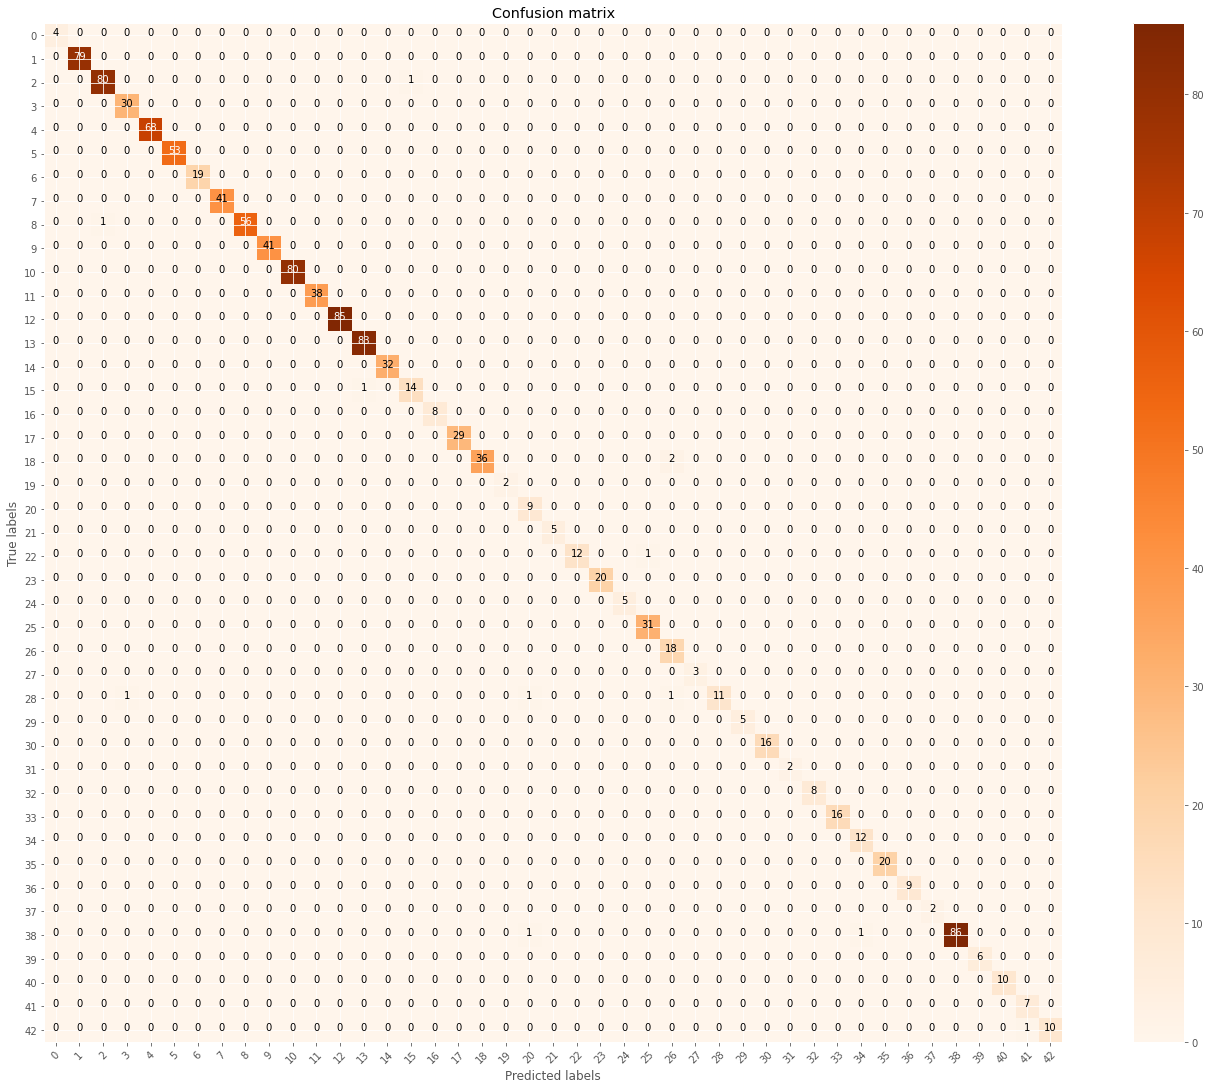

In [72]:
preds = model_classification.predict(test_data_with_cut_bb)
preds = tf.argmax(preds, axis=1)

# Aufbau + Plot der Confusion Matrix
cm = confusion_matrix(tf.argmax(test_labels_classification, axis=1).numpy(), preds.numpy())  
plot_confusion_matrix(cm, tuple(classes))

Die Konfusionsmatrix bestätigt die vorhergehende Evaluation. Es sind fast ausschließlich Einträge in der Diagonalen zu finden. Beim Vergleich mit der Konfusionsmatrix aus dem kombinierten Test (BB-Erkennung und Klassifizierung) werden die Unterschiede in der Performance besonders deutlich.

# Fazit und Ausblick
Es wurde ein Ansatz beschrieben, wie eine Objekterkennung und Klassifizierung im Bereich Verkehrsschilder stattfinden kann. Es ist festzuhalten, dass der orginale Datensatz für das Training der Objekterkennung hochgradig ungeeignet ist. Durch die Generierung von synthetischen Daten leidet die Genauigkeit bei den Vorhersagen bei Bildern aus realen Umgebungen.  
Die Klassifizierung an sich liefert sehr zufriedenstellende Ergebnisse.  
Bei erneuter Bearbeitung oder mehr Zeit hätte der Ansatz eines R-CNN verfolgt werden können, um die Gesamtaufgabe in diesem Rahmen besser zu lösen. Weiterhin ist das "YOLO"-Framework interessant, da es vorgibt, Objekterkennung und Klassifizierung in Echtzeit zu schaffen. Diesen Ansatz haben wir auch verfolgt. Ergebnisse und die Dokumentation sind <a href="ML-allgemein.ipynb">im Notebook zu Yolo zu finden</a>.